## Load data and packages

In [1]:
import random
import numpy as np
import scanpy as sc
import anndata as an
import scipy.stats as st
from scipy.spatial import KDTree
import math
from numba import njit
from numba import jit
from typing import *

import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams["figure.facecolor"] = "white"

DEBUG = False

In [2]:
def prepare_data(adata : an.AnnData, select_hvg : bool = True)-> an.AnnData:
    adata.var_names_make_unique()
    if select_hvg:
        sc.pp.log1p(adata)
        sc.pp.highly_variable_genes(adata)
        adata = adata[:,adata.var.highly_variable_genes.values]
        adata.X = (np.exp(adata.X) -1).round(0)
    return adata

In [49]:
path = "/home/alma/Documents/PhD/master-students/julia/src/Shrink_Le_Dimensions_Alot/spatial-data-synth/20210402100654897026-synth-data.h5ad"
adata = an.read_h5ad(path)
print(adata)
adata = prepare_data(adata,select_hvg=False)

AnnData object with n_obs × n_vars = 100 × 50
    obs: 'spot'
    var: 'gene'
    uns: 'info'
    obsm: 'spatial', 'theta'
    varm: 'phi'


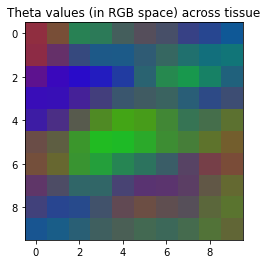

In [50]:
side_length = adata.uns["info"]["side_length"]
plt.imshow(adata.obsm["theta"].reshape(side_length,side_length,3))
plt.title("Theta values (in RGB space) across tissue")
plt.show()


In [5]:
X = adata.X
spots = adata.obs_names
genes = adata.var_names
n_spots = len(adata.obs_names)
n_genes = len(adata.var_names)

## Assign random factors

In [6]:
def assign_random(adata, K):
    """ add short description here

    """
    umi_factor_list = []
    all_n_umis = adata.X.sum(axis=1)
    for n_UMIs in all_n_umis:
        factors = np.random.randint(low = 0,
                                    high = K,
                                    size = int(n_UMIs))
        umi_factor_list.append(factors)
    return umi_factor_list

In [7]:
# this is for testing purpose
def get_gene_identity(adata):
    """ add short description here
    
    Parameters:
    ----------
    """
    n_spots,n_genes = adata.shape
    gene_id_list = []
    X = adata.X
    for spot in range(n_spots):
        gene_id_list.append([])
        for gene in range(n_genes):
            gene_id_list[spot] += [gene] *int(X[spot,gene])
    return gene_id_list

## Get IDs and count matrices

In [8]:
def get_ids_dt_wt(adata: an.AnnData,
                  umi_factors: List[np.ndarray],
                  K: int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """ add short description here
    
    Parameters:
    ----------
    adata : an.AnnData
        anndata object to study
    umi_factors. List[np.ndarray]
        List of arrays. Element j in list i represents
        topic that word j belongs to in spot i
    K: int
        number of topics

    Returns:
    --------
    
    """
    
    n_spots, n_genes = adata.X.shape
    X = adata.X
    ids = []
    dt = np.zeros((n_spots, K))
    wt = np.zeros((K, n_genes))
    
    for spot in range(n_spots):
        ids_spot = []
        spot_list = umi_factors[spot].tolist()
        start = 0
        end = 0
        for gene in range(n_genes):
            n_umis = int(X[spot, gene])
            ids_spot += [gene] * n_umis
            end += n_umis
            for factor in range(K):
                wt[factor, gene] += spot_list[start: end].count(factor)
            start = end
        ids.append(ids_spot)
        for factor in range(K):
            dt[spot, factor] = spot_list.count(factor)
    return ids, dt, wt

In [9]:
# this is for testing purpose
def get_ids_dt_wt_test(gene_ids: List[List[int]],
                  umi_factors: List[np.ndarray],
                  n_genes: int,
                  K: int)->Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """ add short description here
    
    Parameters:
    ----------
    """
    
    n_spots = len(gene_ids)
    dt = np.zeros((n_spots, K))
    wt = np.zeros((K, n_genes))
    
    for spot in range(n_spots):
        for gene,factor in zip(gene_ids[spot],umi_factors[spot]):
            dt[spot,factor] += 1
            wt[factor,gene] += 1
    
    return dt,wt
        

In [10]:
umi_factors = assign_random(adata, 3)
gene_ids = get_gene_identity(adata)
assert len(umi_factors) == len(gene_ids)

In [11]:
# test to see whether proposed implementation
# gives equal result as my attempt
n_spots,n_genes = adata.shape
idx,dt,wt = get_ids_dt_wt(adata,umi_factors,3)
dt_test,wt_test = get_ids_dt_wt_test(gene_ids,umi_factors,n_genes,3)

assert np.all(dt_test==dt)
assert np.all(wt_test == wt)

In [12]:
ids, dt, wt = get_ids_dt_wt(adata, umi_factors, 3)

In [13]:
assert(np.all(np.sum(dt,axis=1) == np.sum(X,axis=1))), "total UMI's in spot and dt rowsums must be equal"

## Functions for calculating theta and phi

In [14]:
def get_theta(dt):
    """ add short description here
    
    Parameters:
    ----------
    """
    n_spots, K = dt.shape
    theta = np.zeros((n_spots, K))
    for spot in range(n_spots):
        for factor in range(K):
            theta[spot, factor] = dt[spot, factor] / np.sum(dt, axis=1)[spot]
    return theta

In [15]:
theta = get_theta(dt)

In [16]:
def get_phi(wt): # I don't use this...
    phi = wt/wt.sum(axis=1, keepdims=True)
    return phi

In [17]:
phi = get_phi(wt)

## Get neighbours and graph edges

In [18]:
def findKNN(adata: an.AnnData,
            n_neighbours: int,
            max_distance: float)->Tuple[List[np.ndarray],List[np.ndarray]]:
    """ add short description here
    
    Parameters:
    ----------
    """
    kd = KDTree(adata.obsm["spatial"])
    dist,indx = kd.query(adata.obsm["spatial"],
                         k = n_neighbours + 1,
                         distance_upper_bound=max_distance, #I added this
                        )
    return dist, indx

In [19]:
dist, indx = findKNN(adata, 4,max_distance = 0.3)

In [20]:
def remove_false_neighbours(dist, indx, eps = 300):
    """ add short description here
    
    Parameters:
    ----------
    """
    dist_sel = []
    indx_sel = []
    for i in range(len(dist)):
        dist_sel.append([])
        indx_sel.append([])
        for j in range(len(dist[i])):
            if dist[i][j] < eps:
                dist_sel[i].append(dist[i][j])
                indx_sel[i].append(indx[i][j])
        dist_sel[i] = np.array(dist_sel[i])
        indx_sel[i] = np.array(indx_sel[i])
    return np.array(dist_sel, dtype=object), np.array(indx_sel, dtype=object)

In [21]:
# for test purposes
def remove_false_neighbours_test(dist,indx):
    """ add short description here
    
    Parameters:
    ----------
    """
    nbr_filter = lambda xs,ds : [x for x,d in zip(xs,ds) if not np.isinf(d)]
    new_idx = [nbr_filter(i,d) for i,d in zip(indx,dist)]
    new_dist = [nbr_filter(d,d) for d in dist]
    return new_dist,new_idx

In [22]:
dist_sel_test,indx_sel_test = remove_false_neighbours_test(dist,indx)
dist_sel, indx_sel = remove_false_neighbours(dist, indx)

In [23]:
# to test if same results are given
for d,d_test,i,i_test in zip(dist_sel,dist_sel_test,indx_sel,indx_sel_test):
    assert np.all(d == np.array(d_test))
    assert np.all(i == np.array(i_test))
    

In [24]:
# you are overcounting neihbours here (at least for visium)
def get_E(indx_sel):
    """ add short description here
    
    Parameters:
    ----------
    """
    edges = 0
    for i in indx_sel:
        edges += len(i) - 1
    return edges

In [25]:
def get_E_test(indx_sel: List[int])->int:
    """ add short description here
    
    Parameters:
    ----------
    """
    # make list to hold neighbor index pairs
    indx_tuples = []
    # iterate over neibhorhoods
    for spot,nbrhd in enumerate(indx_sel):
        # iterate over neihbors in neighborhood
        for nbr in nbrhd[1::]:
            # make a pair (spot,neibhor)
            pair = [spot,nbr]
            # sort pair to store edges the same way
            # (a,b) and (b,a) will now be (a,b) and (a,b)
            pair.sort()
            # store pair, convert to tuple
            indx_tuples.append(tuple(pair))
    # apply set to pair list to remove duplicates
    # will only hold unique edges now
    indx_tuples = set(indx_tuples)
    # return length
    return len(indx_tuples)

In [27]:
E = get_E(indx_sel)
E_test = get_E_test(indx_sel)
assert E == E_test

## Get first lambda and l_dd

In [29]:
@njit(parallel=False)
def bhattacharyya_distance(p: np.ndarray,
                           q: np.ndarray,
                           X: np.ndarray)->float:
    """ add short description here
    
    Parameters:
    ----------
    """
    BC = 0
    for x in range(X):
        BC += math.sqrt(p[x]*q[x])
    DB = - math.log(BC)
    return DB

In [30]:
lambda0 = float(np.random.gamma(0.01, 0.01, 1))

In [31]:
def first_edge_influence(lambda0: float,
                         theta: np.ndarray,
                         indx_sel: List[np.ndarray],
                         K: int)->np.ndarray:
    
    """ add short description here
    
    Parameters:
    ----------
    """
    
    edge_influence = []
    n_spots = len(indx_sel)
    for spot in range(n_spots):
        p = theta[0]
        influences = []
        neighbours = indx_sel[spot][1:]
        for neighbour in neighbours:
            q = theta[neighbour]
            influences.append(np.random.exponential(lambda0 + bhattacharyya_distance(p, q, K)))
        edge_influence.append(influences)
    return np.array(edge_influence, dtype=object)

In [32]:
edge_influence = first_edge_influence(lambda0, theta, indx_sel, 3)

## Functions for Gibbs sampling of variables

In [33]:
def sample_edge_influence(edge_influence: np.ndarray,
                          lambda_parameter: float,
                          theta: np.ndarray,
                          indx_sel: List[np.ndarray],
                          K: int)->None:
    
    
    n_spots = len(indx_sel)
    X = K
    for spot in range(n_spots):
        p = theta[spot]
        index = 1
        n_neighbours = len(indx_sel[spot][1:])
        for index in range(n_neighbours):
            neighbour = indx_sel[spot][index+1]
            q = theta[neighbour]
            edge_influence[spot][index] = np.random.exponential(lambda_parameter + Bhatt_dist(p, q, X))

In [34]:
def sample_lambda(E: int,
                  edge_influence: float,
                  lambda_a = 0.01,
                  lambda_b = 0.01):
    
    """ add short description here
    
    Parameters:
    ----------
    """
    
    sum_edge_influences = 0
    for edge in edge_influence:
        sum_edge_influences += sum(edge)
    shape = lambda_a + E
    rate = 1 / (lambda_b + sum_edge_influences)
    lambda_parameter = np.random.gamma(shape, rate, 1)
    return lambda_parameter

In [40]:
lambda_parameter = sample_lambda(E, edge_influence)

In [35]:
def draw_new_factor(umi_factors,
                    ids,
                    spot,
                    w,
                    dt,
                    wt,
                    theta,
                    K,
                    beta = 0.1):
    
    """ add short description here
    
    Parameters:
    ----------
    """
    factor0 = umi_factors[spot][w]
    gene_id = ids[spot][w]
    dt[spot, factor0] -= 1 # spots x topics
    wt[factor0, gene_id] -= 1 # factor x genes
    
    left = theta[spot,:]
    # old
    #right = (wt[:,gene_id] + beta) / (wt.sum(axis=0)[gene_id] + K * beta)
    # new
    right = (wt[:,gene_id] + beta)
    right /= right.sum()
    pvals = left*right
    pvals = pvals / pvals.sum()
    
    factor1 = np.argmax(np.random.multinomial(1,pvals))
    dt[spot, factor1] +=  1
    wt[factor1, gene_id] += 1
    umi_factors[spot][w] = factor1

In [ ]:
draw_new_factor(umi_factors, ids, 0, 0, dt, wt, theta, 3)

## Metropolis-Hastings sampling of theta

In [36]:
# we need to do MH at each step of the gibbs sampling
# I've suggested a new solution below
def metr_hast(theta, indx_sel, edge_influence, lambda_parameter, iterations = 1000):
    
    # Prepare proposal distribution    
    dist_g = lambda x: np.random.dirichlet(x)

    n_spots, X = theta.shape
    
    # Metropolis-Hastings sampling
    for it in range(iterations):
        for spot in range(n_spots):
            log_a_prob0 = 0 # Cannot use from last Gibbs iteration, because there will be new edge_infl and lambdas.
            log_a_prob1 = 0
            p0 = theta[spot]
            p1 = dist_g(np.sum(theta, axis=0)) 
            neighbours = indx_sel[spot][1:]
            index = 0
            for neighbour in neighbours:
                q = theta[neighbour]
                log_edge_potential0 = - Bhatt_dist(p0,q,X) * edge_influence[spot][index] # Double check
                log_edge_potential1 = - Bhatt_dist(p1,q,X) * edge_influence[spot][index]
                log_a_prob0 += log_edge_potential0
                log_a_prob1 += log_edge_potential1
                index += 1
            a_prob = min(1, np.exp(log_a_prob1 - log_a_prob0)) 
#            print(a_prob) # This is really large. Maybe that's normal because everything is better than random?
            if np.random.random() < a_prob:
                p0 = p1
            theta[spot] = p0

In [37]:
def metropolis_hastings(spot,
                        theta,
                        dt,
                        indx_sel,
                        alpha_orig,
                        edge_influence,
                        n_iter = 1000):
    
    n_topics = theta.shape[1]
    accepted = 0
    
    def log_target_dist(theta_eval):
        l_prob = 0
        for k,nbr in enumerate(indx_sel[spot][1::]):
            l_prob -=  edge_influence[spot][k]*\
            bhattacharyya_distance(theta_eval,theta[nbr],n_topics)
        return l_prob
    
    proposal_dist = st.dirichlet(alpha_orig + dt.sum(axis=0))
    
    old_theta = proposal_dist.rvs()[0]
    old_log_proposal = proposal_dist.logpdf(old_theta)
    old_log_target = log_target_dist(old_theta)
            
    for it in range(n_iter):
        new_theta = proposal_dist.rvs()[0]
        new_log_proposal = proposal_dist.logpdf(new_theta)
        new_log_target = log_target_dist(new_theta)
        
        log_u = new_log_target + old_log_proposal - old_log_target - new_log_proposal
        u = np.exp(log_u)
        a = min(u,1)
        if np.random.random() < a:
            old_theta = new_theta
            old_log_proposal = new_log_proposal
            old_log_target = new_log_target
            
            accepted += 1
        
    if DEBUG: print("Fraction of accepted proposals : {}".format(accepted / n_iter))
            
    return old_theta

In [ ]:
%%time
for ii in range(100):
    metropolis_hastings(0,theta,dt,indx_sel,np.ones(theta.shape[1]),edge_influence,n_iter=1000)

In [ ]:
%%time
# 10 iterations
metr_hast(theta, indx_sel, edge_influence, lambda_parameter, iterations = 10)

In [ ]:
%%time
# 1000 iterations
metr_hast(theta, indx_sel, edge_influence, lambda_parameter)

## Gibbs sampling

In [38]:
def Gibbs(umi_factors,
          ids,
          dt,
          wt,
          theta,
          K, iterations,
          edge_influence,
          lambda_parameter,
          indx_sel,
          E,
          beta = 0.1):

    alpha_orig = np.ones(K)
    for it in range(iterations):
        for spot in range(len(umi_factors)):
            for w in range(len(umi_factors[spot])):
                draw_new_factor(umi_factors, ids, spot, w, dt, wt, theta, K)
                sample_edge_influence(edge_influence, lambda_parameter, theta, indx_sel, K)
                lambda_parameter = sample_lambda(E, edge_influence, lambda_a = 0.01, lambda_b = 0.01)
                theta[spot,:] = metropolis_hastings(spot,theta,dt,indx_sel,alpha_orig,edge_influence,n_iter =20)
                

In [41]:
%%time
DEBUG = False
Gibbs(umi_factors, ids, dt, wt, theta, 3, 1, edge_influence, lambda_parameter, indx_sel, E)

CPU times: user 20.4 s, sys: 25.1 ms, total: 20.4 s
Wall time: 20.4 s
